In [1]:
#!pip install pyyaml==5.1
import torch
import torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

1.9.0+cu111 True
gcc (Gentoo 10.3.1_p20211126 p0) 10.3.1 20211126
Copyright (C) 2020 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [12]:
print(torch.cuda.get_device_properties(0).total_memory/1e9)
print(torch.cuda.memory_reserved(0)/1e9)
print(torch.cuda.memory_allocated(0)/1e9)

25.447170048
23.368564736
21.921205248


In [2]:
#%matplotlib notebook
import glob
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import Image
import time

from shapely.geometry import Polygon

# importing required libraries
import pandas as pd
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import pandas as pd
from get_iou import get_max_iou, get_iou, get_overlap
import pickle
import random
import json
import os
from collections import Counter
import cv2
import numpy as np

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
from detectron2.engine import DefaultTrainer

from os import path

In [3]:
from metric_tablebank import metric_table_bank_union

# Get data

In [4]:
path_data = "/data/rali5/Tmp/yockelle/TableBank/TableBank/Detection/"

In [5]:
def get_valid_data():
    latex = pickle.load( open(path_data + "annotations/COCO_tablebank_latex_val.pickle", "rb" ) )
    word = pickle.load( open(path_data + "annotations/COCO_tablebank_word_val.pickle", "rb" ) )
    return latex + word
    
# TRAINING DATA
def get_train_data_latex():
    latex = pickle.load( open(path_data + "annotations/COCO_tablebank_latex_train.pickle", "rb" ) )
    return latex

def get_train_data_word():
    word = pickle.load( open(path_data + "annotations/COCO_tablebank_word_train.pickle", "rb" ) )
    return word

def get_train_data_both():
    latex = get_train_data_latex()
    word = get_train_data_word()
    total_train = latex + word
    random.shuffle(total_train)
    return total_train

def get_train_data_latex_pln():
    latex = get_train_data_latex()
    pln = get_train_data_publaynet()
    total_train = latex + pln
    random.shuffle(total_train)
    return total_train

def get_train_data_word_pln():
    word = get_train_data_word()
    pln = get_train_data_publaynet()
    total_train = word + pln
    random.shuffle(total_train)
    return total_train

def get_train_data_pln_latex_word():
    latex = get_train_data_latex()
    word = get_train_data_word()
    publaynet = get_train_data_publaynet()
    total_train = latex + word + publaynet
    random.shuffle(total_train)
    return total_train

# TEST DATA
def get_test_data_latex():
    latex = pickle.load( open(path_data + "annotations/COCO_tablebank_latex_test.pkl", "rb" ) )
    return latex

def get_test_data_word():
    word = pickle.load( open(path_data + "annotations/COCO_tablebank_word_test.pkl", "rb" ) )
    return word

def get_test_data_both():
    latex = get_test_data_latex()
    word = get_test_data_word()
    total_test = latex + word
    random.shuffle(total_test)
    return total_test

def get_test_data_publaynet():
    test_publaynet = pickle.load( open("../PubLayNet/COCO_test_set_table_only.pkl", "rb" ) )
    for image in test_publaynet:
        annotation_array = []
        for annot in image["annotations"]:
            annot["category_id"] = 0
            annotation_array.append(annot)
        image['categories'] = [{'supercategory': '', 'id': 0, 'name': 'table'}]
        image["annotations"] = annotation_array
        image["file_name"] = "/data/rali5/Tmp/yockelle/PubLayNet/" + image["file_name"]
    return test_publaynet

def get_train_data_publaynet():
    train_publaynet = pickle.load( open("../PubLayNet/COCO_train_set_table_only.pkl", "rb" ) )
    for image in train_publaynet:
        annotation_array = []
        for annot in image["annotations"]:
            annot["category_id"] = 0
            annotation_array.append(annot)
        image['categories'] = [{'supercategory': '', 'id': 0, 'name': 'table'}]
        image["annotations"] = annotation_array
        image["file_name"] = "/data/rali5/Tmp/yockelle/PubLayNet/" + image["file_name"]
    return train_publaynet


def get_train_data_pln_and_empty():
    no_table = pickle.load( open("../PubLayNet/COCO_no_table_examples.pkl", "rb" ) )
    for image in no_table:
        image['categories'] = [{'supercategory': '', 'id': 0, 'name': 'table'}]
        image["annotations"] = []
        image["file_name"] = "/data/rali5/Tmp/yockelle/PubLayNet/" + image["file_name"]

    train = get_train_data_publaynet()
    total_test = no_table + train
    random.shuffle(total_test)

    return total_test


def get_train_data_and_word_pln_empty():

    word = get_train_data_word()

    no_table = pickle.load( open("../PubLayNet/COCO_no_table_examples.pkl", "rb" ) )
    for image in no_table:
        image['categories'] = [{'supercategory': '', 'id': 0, 'name': 'table'}]
        image["annotations"] = []
        image["file_name"] = "/data/rali5/Tmp/yockelle/PubLayNet/" + image["file_name"]

    train = get_train_data_publaynet()
    total_test = no_table + train + word
    random.shuffle(total_test)

    return total_test

def get_train_data_and_latex_pln_empty():

    latex = get_train_data_latex()

    no_table = pickle.load( open("../PubLayNet/COCO_no_table_examples.pkl", "rb" ) )
    for image in no_table:
        image['categories'] = [{'supercategory': '', 'id': 0, 'name': 'table'}]
        image["annotations"] = []
        image["file_name"] = "/data/rali5/Tmp/yockelle/PubLayNet/" + image["file_name"]

    train = get_train_data_publaynet()
    total_test = no_table + train + latex
    random.shuffle(total_test)

    return total_test

def get_train_data_word_and_latex_pln_empty():

    latex = get_train_data_both()

    no_table = pickle.load( open("../PubLayNet/COCO_no_table_examples.pkl", "rb" ) )
    for image in no_table:
        image['categories'] = [{'supercategory': '', 'id': 0, 'name': 'table'}]
        image["annotations"] = []
        image["file_name"] = "/data/rali5/Tmp/yockelle/PubLayNet/" + image["file_name"]

    train = get_train_data_publaynet()
    total_test = no_table + train + latex
    random.shuffle(total_test)

    return total_test

In [6]:
train_set_name = "my_dataset_train"
valid_set_name = "my_dataset_valid"
test_set_name = "my_dataset_test"

# Train set
DatasetCatalog.register(train_set_name, get_train_data_latex)
MetadataCatalog.get(train_set_name).set(thing_classes=["table"])
text_metadata_train = MetadataCatalog.get(train_set_name)

# Validation set
DatasetCatalog.register(valid_set_name, get_valid_data)
MetadataCatalog.get(valid_set_name).set(thing_classes=["table"])
text_metadata_valid = MetadataCatalog.get(valid_set_name)

# Test set
DatasetCatalog.register(test_set_name, get_test_data_both)
MetadataCatalog.get(test_set_name).set(thing_classes=["table"])
text_metadata_test = MetadataCatalog.get(test_set_name)

In [7]:
class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [10]:
cfg = get_cfg()
cfg.merge_from_file("/data/rali5/Tmp/yockelle/TableBank/TableBank/output/latex/X152/config_latex_X152.yaml")
cfg.DATASETS.TRAIN = (train_set_name,)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/data/rali5/Tmp/yockelle/TableBank/TableBank/output/latex/X152/model_final_latex_X152.pth")
#cfg.SOLVER.IMS_PER_BATCH = 4
#cfg.SOLVER.BASE_LR = 0.0125  # pick a good LR
#cfg.SOLVER.BASE_LR = 0.0125  # pick a good LR
#cfg.SOLVER.MAX_ITER = 3000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
#cfg.SOLVER.STEPS = []        # do not decay learning rate
#cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
#cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
#cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = 0.5
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.TEST.EVAL_PERIOD = 1000
CUDA_LAUNCH_BLOCKING = 1

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
#trainer = DefaultTrainer(cfg) 
trainer = CocoTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[01/22 11:07:44 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


[01/22 11:07:52 d2.engine.train_loop]: Starting training from iteration 0


/u/yockelle/.local/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/u/yockelle/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


ERROR [01/22 11:07:54 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/u/yockelle/.local/lib/python3.8/site-packages/detectron2/engine/train_loop.py", line 149, in train
    self.run_step()
  File "/u/yockelle/.local/lib/python3.8/site-packages/detectron2/engine/defaults.py", line 497, in run_step
    self._trainer.run_step()
  File "/u/yockelle/.local/lib/python3.8/site-packages/detectron2/engine/train_loop.py", line 273, in run_step
    loss_dict = self.model(data)
  File "/u/yockelle/.local/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1051, in _call_impl
    return forward_call(*input, **kwargs)
  File "/u/yockelle/.local/lib/python3.8/site-packages/detectron2/modeling/meta_arch/rcnn.py", line 154, in forward
    features = self.backbone(images.tensor)
  File "/u/yockelle/.local/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1051, in _call_impl
    return forward_call(*input, **kwargs)
  File "/u/yockelle/.

RuntimeError: CUDA out of memory. Tried to allocate 1.32 GiB (GPU 0; 23.70 GiB total capacity; 20.42 GiB already allocated; 321.69 MiB free; 21.76 GiB reserved in total by PyTorch)

In [9]:
"""
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3   # set the testing threshold for this model
cfg.DATASETS.TEST = (test_set_name, )
predictor = DefaultPredictor(cfg)
"""

cfg = get_cfg()
cfg.merge_from_file("/data/rali5/Tmp/yockelle/TableBank/TableBank/output/latex/X152/config_latex_X152.yaml")
cfg.DATASETS.TRAIN = (train_set_name,)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/data/rali5/Tmp/yockelle/TableBank/TableBank/output/latex/X152/model_final_latex_X152.pth")
cfg.SOLVER.IMS_PER_BATCH = 4
#cfg.SOLVER.BASE_LR = 0.0125  # pick a good LR
#cfg.SOLVER.MAX_ITER = 7000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
#cfg.SOLVER.STEPS = []        # do not decay learning rate
#cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = 0.5
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.TEST.EVAL_PERIOD = 1000
CUDA_LAUNCH_BLOCKING = 1
predictor = DefaultPredictor(cfg)

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [33]:
test_data = get_test_data_word()
threshold = 0.975

precision_tab = []
recall_tab = []

sum_numerator = 0
sum_numerator_old = 0
sum_denominator_precision = 0
sum_denominator_recall = 0

test_count = 0

for i in range(len(test_data)):
  if i%1000 == 0:
    print(i)
  image_dict = test_data[i]
  image_name = "/data/rali5/Tmp/yockelle/TableBank/" + image_dict["file_name"]
  im = cv2.imread(image_name)
  outputs = predictor(im)

  predictions_detectron = outputs["instances"].pred_boxes.tensor.cpu().numpy()
  scores_detectron = outputs["instances"].scores.cpu().numpy()
  predictions_with_threshold = []
  for j, p in enumerate(predictions_detectron):
    if scores_detectron[j]>threshold:
      predictions_with_threshold.append(p)
  predictions_with_threshold = np.array(predictions_with_threshold)

  # Get the ground truth
  bbox_ground_truth = []
  truth = image_dict["annotations"]
  for t in truth:
      x_min = t["bbox"][0]
      y_min = t["bbox"][1]
      w = t["bbox"][2]
      h = t["bbox"][3]
      x_max = x_min + w
      y_max = y_min + h
      bbox_ground_truth.append([x_min, y_min, x_max, y_max])

  result = metric_table_bank_union(bbox_ground_truth, predictions_with_threshold)

  if result != None:
    test_count += 1
    numerator, denominator_precision, denominator_recall, old_way_area_union = result

    sum_numerator += numerator
    sum_numerator_old += old_way_area_union
    sum_denominator_precision += denominator_precision
    sum_denominator_recall += denominator_recall

precision = sum_numerator/sum_denominator_precision
recall = sum_numerator/sum_denominator_recall
f1 = (2 * precision * recall) / (precision + recall)

print("Precision ", precision)
print("Recall ", recall)
print("F1 ", f1)

0
1000
2000
Precision  0.9611628518892508
Recall  0.8376718111558195
F1  0.895178465812773


In [16]:
test_latex_predictions = {}
test_latex_truth = {}

test_data = get_test_data_both() + get_test_data_publaynet()

count_pred = 0
count_truth = 0

all_image_preds = []
all_annotations_preds = []

all_image_truth = []
all_annotations_truth = []

sum_numerator = 0
sum_numerator_old = 0
sum_denominator_precision = 0
sum_denominator_recall = 0

for index, image_dict in enumerate(test_data):
  one_image_pred = {}
  one_image_truth = {}
  
  if index%500 == 0:
    print(index)

  try: 
    image_name = "/data/rali5/Tmp/yockelle/TableBank/" + image_dict["file_name"]  
    im = cv2.imread(image_name).shape
  except:
    image_name = image_dict["file_name"]
    im = cv2.imread(image_name).shape
  #image_name = "/data/rali5/Tmp/yockelle/PubLayNet/" + image_dict["file_name"]
  #image_name = image_dict["file_name"]
  only_name = image_dict["file_name"].split("/")[-1]

  truths_boxes = []
  preds_boxes = []

  problem = False

  # ADD TRUTH
  for annot in image_dict["annotations"]:
    #if scores_detectron[j]>threshold:
    p = annot["bbox"]
    x1 = p[0]
    y1 = p[1]
    w = p[2]
    h = p[3]
    x2 = p[0] + w
    y2 = p[1] + h
    if y1 == y2 or y2<y1:
      #print("here")
      #print(count_truth)
      problem = True
      break

    if not(problem):
      
      one_annotations = {}
      one_annotations["id"] = count_truth
      one_annotations["segmentation"] = []
      one_annotations["area"] = float(w * h)
      one_annotations["iscrowd"] = 0
      one_annotations["ignore"] = 0
      one_annotations["image_id"] = index
      one_annotations["bbox"] = [float(pp) for pp in p]
      one_annotations["category_id"] = 0

      all_annotations_truth.append(one_annotations)
      count_truth += 1

      truths_boxes.append([x1,y1,x2,y2])

  if problem:
    continue

  if problem:
    print("wtf")

  one_image_truth["id"] = index
  one_image_truth["file_name"] = only_name
  one_image_truth["width"] = image_dict["width"]
  one_image_truth["height"] = image_dict["height"]

  all_image_truth.append(one_image_truth)
  

  # ADD PREDS
  im = cv2.imread(image_name)
  outputs = predictor(im)
  predictions_detectron = outputs["instances"].pred_boxes.tensor.cpu().numpy()
  scores_detectron = outputs["instances"].scores.cpu().numpy()

  for j, p in enumerate(predictions_detectron):
    #if scores_detectron[j]>threshold:
    x1 = p[0]
    y1 = p[1]
    x2 = p[2]
    y2 = p[3]
    w = x2-x1
    h = y2-y1
    #x2 = p[0] + w
    #y2 = p[1] + h
    
    one_annotations = {}
    one_annotations["id"] = count_pred
    one_annotations["segmentation"] = []
    one_annotations["area"] = float(w * h)
    one_annotations["iscrowd"] = 0
    one_annotations["ignore"] = 0
    one_annotations["image_id"] = index
    one_annotations["bbox"] = [float(pp) for pp in [x1,y1,w,h]]
    one_annotations["category_id"] = 0
    one_annotations["score"] = float(scores_detectron[j])

    all_annotations_preds.append(one_annotations)
    count_pred += 1

    preds_boxes.append([x1,y1,x2,y2])

  one_image_pred["id"] = index
  one_image_pred["file_name"] = only_name
  one_image_pred["width"] = image_dict["width"]
  one_image_pred["height"] = image_dict["height"]

  all_image_preds.append(one_image_pred)

  result = metric_table_bank_union(np.array(truths_boxes), np.array(preds_boxes))
  numerator, denominator_precision, denominator_recall, old_way_area_union = result

  sum_numerator += numerator
  sum_numerator_old += old_way_area_union
  sum_denominator_precision += denominator_precision
  sum_denominator_recall += denominator_recall


# ADD TRUTHS
test_latex_truth["images"] = all_image_truth
test_latex_truth["annotations"] = all_annotations_truth
test_latex_truth["categories"] = [{"id": 0, "name": "table", "supercategory": "none"}]

test_type = "word-latex-publaynet"
train_type = "latex"

path_truth = "prediction_and_truth_models/train_"+train_type+"/annotations_test_"+test_type+"/truth"
if not path.exists(path_truth):
  os.makedirs(path_truth)
out_file = open(path_truth + "/test_"+test_type+"_truth.json", "w")
json.dump(test_latex_truth, out_file, indent = 6)
out_file.close()
  
# ADD PREDS
test_latex_predictions["images"] = all_image_preds
test_latex_predictions["annotations"] = all_annotations_preds
test_latex_predictions["categories"] = [{"id": 0, "name": "table", "supercategory": "none"}]

path_pred = "prediction_and_truth_models/train_"+train_type+"/annotations_test_"+test_type+"/preds"
if not path.exists(path_pred):
  os.makedirs(path_pred)
out_file = open(path_pred + "/test_"+test_type+"_preds.json", "w")
json.dump(test_latex_predictions, out_file, indent = 6)
out_file.close()

precision = sum_numerator/sum_denominator_precision
recall = sum_numerator/sum_denominator_recall
f1 = (2 * precision * recall) / (precision + recall)

print("First")
print("Precision ", precision)
print("Recall ", recall)
print("F1 ", f1)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
First
Precision  0.8011931394705466
Recall  0.9880021048699609
F1  0.8848453076411419


# Make Precision-Recall curve

In [8]:
test_data = get_test_data_both()
#threshold_pred = [0.0, 0.6, 0.8, 0.95, 0.97, 0.99]

threshold_pred = [0.975, 0.98, 0.985]

recall_with_threshold = []
precision_with_threshold = []

for threshold_ind, threshold in enumerate(threshold_pred):
  print(threshold)

  precision_tab = []
  recall_tab = []

  sum_numerator = 0
  sum_numerator_old = 0
  sum_denominator_precision = 0
  sum_denominator_recall = 0

  test_count = 0

  for i in range(len(test_data)):
    if i%4000 == 0:
      print(i)
    image_dict = test_data[i]
    image_name = "/data/rali5/Tmp/yockelle/TableBank/" + image_dict["file_name"]
    im = cv2.imread(image_name)
    outputs = predictor(im)

    predictions_detectron = outputs["instances"].pred_boxes.tensor.cpu().numpy()
    scores_detectron = outputs["instances"].scores.cpu().numpy()
    predictions_with_threshold = []
    for j, p in enumerate(predictions_detectron):
      if scores_detectron[j]>threshold:
        predictions_with_threshold.append(p)
    predictions_with_threshold = np.array(predictions_with_threshold)

    # Get the ground truth
    bbox_ground_truth = []
    truth = image_dict["annotations"]
    for t in truth:
        x_min = t["bbox"][0]
        y_min = t["bbox"][1]
        w = t["bbox"][2]
        h = t["bbox"][3]
        x_max = x_min + w
        y_max = y_min + h
        bbox_ground_truth.append([x_min, y_min, x_max, y_max])

    result = metric_table_bank_union(bbox_ground_truth, predictions_with_threshold)

    if result != None:
      test_count += 1
      numerator, denominator_precision, denominator_recall, old_way_area_union = result

      #precision_tab.append(precision)
      #recall_tab.append(recall)

      sum_numerator += numerator
      sum_numerator_old += old_way_area_union
      sum_denominator_precision += denominator_precision
      sum_denominator_recall += denominator_recall

  precision = sum_numerator/sum_denominator_precision
  recall = sum_numerator/sum_denominator_recall
  f1 = (2 * precision * recall) / (precision + recall)

  precision_with_threshold.append(precision)
  recall_with_threshold.append(recall)

  #precision_old = sum_numerator_old/sum_denominator_precision
  #recall_old = sum_numerator_old/sum_denominator_recall
  #f1_old = (2 * precision_old * recall_old) / (precision_old + recall_old)

  print("precision ", precision)
  print("recall ", recall)
  print("f1 ", f1)

with open('X101model_recall_with_threshold_latex-word_0.975_0.98_0.985.pkl', 'wb') as f:
  pickle.dump(recall_with_threshold, f)

with open('X101model_precision_with_threshold_latex-word_0.975_0.98_0.985.pkl', 'wb') as f:
    pickle.dump(precision_with_threshold, f)


0.975
0


/u/yockelle/.local/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/u/yockelle/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


4000
precision  0.972882911193473
recall  0.8826494957488177
f1  0.92557220534092
0.98
0
4000
precision  0.9743411233985767
recall  0.8630515724902792
f1  0.9153259840126777
0.985
0
4000
precision  0.9786959817391115
recall  0.8351469028012577
f1  0.9012411437615495


In [14]:
with open('image_curve/v2_recall_with_threshold_latex-word.pkl', 'rb') as f:
    recall_with_threshold = pickle.load(f)

with open('image_curve/v2_precision_with_threshold_latex-word.pkl', 'rb') as f:
    precision_with_threshold = pickle.load(f)

In [16]:
recall = recall_with_threshold[6]
precision = precision_with_threshold[6]

print((2 * precision * recall) / (precision + recall))

0.904122891197051


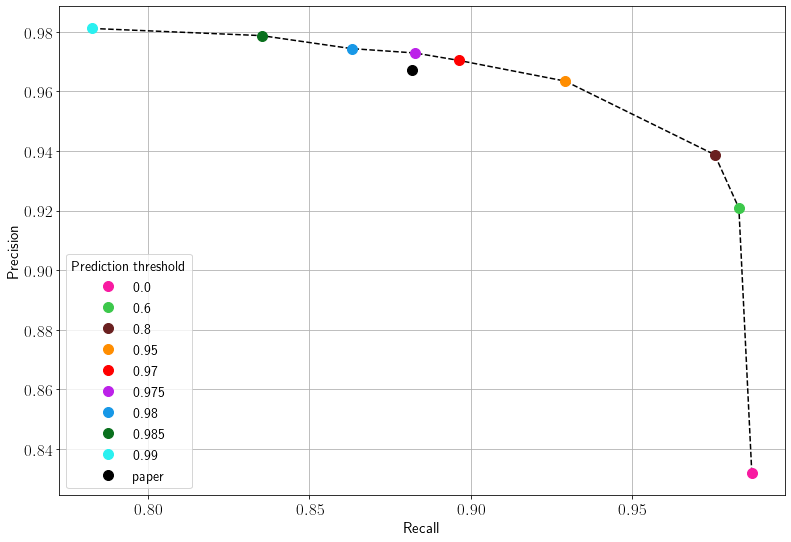

In [20]:
with open('image_curve/X101model_recall_with_threshold_latex-word.pkl', 'rb') as f:
    recall_with_threshold = pickle.load(f)

with open('image_curve/X101model_precision_with_threshold_latex-word.pkl', 'rb') as f:
    precision_with_threshold = pickle.load(f)

threshold_pred = [0.0, 0.6, 0.8, 0.95, 0.97, 0.975, 0.98, 0.985, 0.99]

plt.figure(figsize=(13, 9))

plt.rcParams['text.usetex']=True
plt.rc({
    "font.family": "serif",
    "font.serif": ["Palatino"]})

colors_choices = ["#f81aa1", "#3cc84b", "#6a2020", "#ff8d00", "#ff0000", "#bc21e9", "#1798e7", "#09701d", "#2af0f0"]

plt.plot(recall_with_threshold, precision_with_threshold, '--', color="k")

for thresh_ind, threshold in enumerate(threshold_pred):
  plt.plot(recall_with_threshold[thresh_ind], precision_with_threshold[thresh_ind], 'o', markersize=10, color=colors_choices[thresh_ind], label=threshold)

plt.plot(0.8817, 0.9670, 'o', markersize=10, color="k", label="paper")

plt.grid()
plt.xlabel('Recall', fontsize=15)
plt.ylabel('Precision', fontsize=15)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
#plt.xlim(min(recall_with_threshold)-0.009, 1.0)
#plt.ylim(min(precision_with_threshold)-0.02, 1.0)
plt.legend(prop={'size': 14}, title="Prediction threshold", title_fontsize=14)
plt.savefig("X101model-precision_latex-word.png")
plt.show()


In [14]:
test_data = get_test_data_both()

precision_tab = []
recall_tab = []

sum_numerator = 0
sum_denominator_precision = 0
sum_denominator_recall = 0

test_count = 0

for i in  range(len(test_data)):
  if not i%100:
    print(i)

  image_dict = test_data[i]
  image_name = "/data/rali5/Tmp/yockelle/TableBank/" + image_dict["file_name"]
  im = cv2.imread(image_name)
  outputs = predictor(im)

  predictions_detectron = outputs["instances"].pred_boxes.tensor.cpu().numpy()

  # Get the ground truth
  bbox_ground_truth = []
  truth = image_dict["annotations"]
  for t in truth:
      x_min = t["bbox"][0]
      y_min = t["bbox"][1]
      w = t["bbox"][2]
      h = t["bbox"][3]
      x_max = x_min + w
      y_max = y_min + h
      bbox_ground_truth.append([x_min, y_min, x_max, y_max])

  result = measure_metric_table_bank(bbox_ground_truth, predictions_detectron)

  if result != None:
    test_count += 1
    precision, recall, numerator, denominator_precision, denominator_recall = result

    #precision_tab.append(precision)
    #recall_tab.append(recall)

    sum_numerator += numerator
    sum_denominator_precision += denominator_precision
    sum_denominator_recall += denominator_recall

precision = sum_numerator/sum_denominator_precision
recall = sum_numerator/sum_denominator_recall
f1 = (2 * precision * recall) / (precision + recall)
print(sum_numerator)
print(sum_denominator_precision)
print(sum_denominator_recall)

0


/u/yockelle/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900


ZeroDivisionError: division by zero

In [19]:
print("Old way with only intersect")
print("precision ", precision)
print("recall ", recall)
print("f1 ", f1)

Old way with only intersect
precision  0.7458786797677166
recall  0.9658888741440649
f1  0.841745033199794
